# Navier-Stokes: Transient Lid-driven Cavity Flow

---

This notbook solves a special case of the Navier-Stokes equations, the lid-driven cavity flow. More precisely the lid driven cavity with a flexible bottom surface It is an important system for the study of incompressible flows and it is also used as an benchmark for numerical methods. The following example was taken from [Ghia et al. 1982](https://doi.org/10.1016/0021-9991(82)90058-4).

Considering the Navier-Stokes equation: 

$$\frac{\partial\mathbf{u}}{\partial\mathbf{t}} + \mathbf{u}\cdot\nabla \mathbf{u}=-\nabla p + \frac{1}{Re}\Delta \mathbf{u}$$

and the continuity equation:

$$\nabla \cdot \mathbf{u}=0,$$ 

Let $Re=100$, $\mathbf{u}=(u,v,t)$ the velocity vector field and $p$ the pressure. 

The domain is the rectangle $[0,1]^2$ with the following Dirichlet boundary conditions:

- Left, right and bottom walls
$$
u(0,y,t)=u(x,0,t)=u(1,y,t)=v(0,y,t)=v(x,0,t)=v(1,y,t)=v(x,1,t)=0
$$

- Top wall (lid):
$$
u(x,1,t)=1
$$

- Pressure
$$
p(0,0,t)=0
$$

And initial condtions:
$$
    u(x,y,0)=0 \qquad u(x,y,0)=0
$$




In [23]:
import numpy as np
import torch
import os

# Set torch as the backend for DeepXDE
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde
from plot import test_and_plot_graphs, plot_loss_evolution

# Increases floating point precision
dde.config.set_default_float('float64')


Set the default float type to float64


In [24]:
# Coeficients and space/time domain limits

Re = 100

x0, xf = 0, 1
y0, yf = 0, 1
t0, tf = 0, 2

In [25]:

def transient_cavity_flow_pde(x, y):
    """
    2D transient cavity flow loss function.
    """
    
    u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:3]

    # Derivate u velocity by (x, y, t)
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)

    # Derivate v velocity by (x, y, t)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)

    # Derivate pressure by (x, y). No derivate by time, since the preassure is constant
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)

    # Compute second derivatives for viscous term
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    # Navier-Stokes equations
    momentum_x = du_t + u * du_x + v * du_y + dp_x - (1 / Re) * (du_xx + du_yy)
    momentum_y = dv_t + u * dv_x + v * dv_y + dp_y - (1 / Re) * (dv_xx + dv_yy)
    continuity = du_x + dv_y

    return [momentum_x, momentum_y, continuity]
    
    

In [26]:

# Define space domain
geometry = dde.geometry.Rectangle([x0, y0], [xf, yf])

# Define time interval
timeinterval = dde.geometry.TimeDomain(t0, tf)

# Space-time domain
geomtime = dde.geometry.GeometryXTime(geometry, timeinterval)

# Boundary condtions for each cavity wall
def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1.0)

def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)

def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)

# Velocity boundary condtions for u
u_t_bc = dde.icbc.DirichletBC(geomtime, lambda x: 1, boundary_top, component=0)
u_r_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_right, component=0)
u_l_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_left, component=0)
u_b_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_bottom, component=0)

# Velocity boundary condtions for v
v_t_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_top, component=1)
v_r_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_right, component=1)
v_l_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_left, component=1)
v_b_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_bottom, component=1)

# Pressure boundary condition
# https://github.com/lululxvi/deepxde/discussions/1432
p_o_bc = dde.icbc.PointSetBC([[0,0,0]], [0], component=2)

# Initial conditions
u_ic = dde.icbc.IC(geomtime, lambda x: 0, lambda _, on_initial: on_initial, component=0)
v_ic = dde.icbc.IC(geomtime, lambda x: 0, lambda _, on_initial: on_initial, component=1)

# Combining all boundary conditions
bcs = [u_t_bc, u_r_bc, u_l_bc, u_b_bc, v_t_bc, v_r_bc, v_l_bc, v_b_bc, p_o_bc, u_ic, v_ic]


Compiling model...
'compile' took 0.000087 s

Training model...

0         [1.89e-03, 4.19e-03, 3.54e-02, 1.66e+00, 1.07e-01, 2.46e-02, 4.02e-02, 2.09e-03, 1.14e-03, 5.34e-03, 4.05e-03, 0.00e+00, 3.38e-02, 4.14e-04]    [1.75e-03, 3.84e-03, 3.55e-02, 1.66e+00, 1.07e-01, 2.46e-02, 4.02e-02, 2.09e-03, 1.14e-03, 5.34e-03, 4.05e-03, 0.00e+00, 3.38e-02, 4.14e-04]    []  
5         [2.91e-03, 1.79e-04, 8.14e-03, 9.47e-01, 1.95e-03, 3.54e-03, 7.38e-04, 6.28e-04, 2.03e-03, 4.49e-05, 5.84e-04, 2.60e-08, 1.06e-03, 8.74e-04]    [3.17e-03, 1.83e-04, 8.12e-03, 9.47e-01, 1.95e-03, 3.54e-03, 7.38e-04, 6.28e-04, 2.03e-03, 4.49e-05, 5.84e-04, 2.60e-08, 1.06e-03, 8.74e-04]    []  

Best model at step 5:
  train loss: 9.69e-01
  test loss: 9.70e-01
  test metric: []

'train' took 2.265819 s



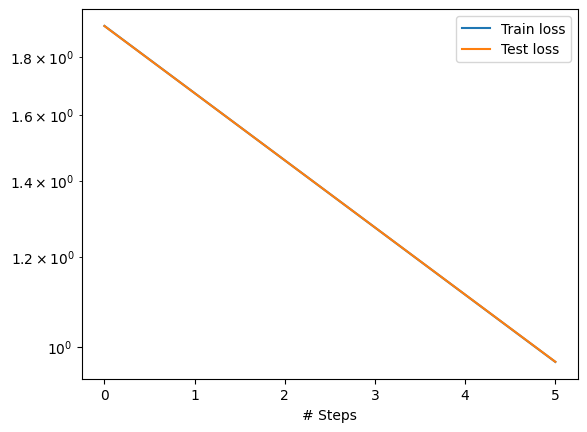

In [ ]:

# Ceate training data points
data = dde.data.TimePDE(
    geomtime,
    transient_cavity_flow_pde,
    bcs,
    num_domain=1800,
    num_initial=200,
    num_boundary=250,
    num_test=1800,
)

# 4 hidden layers with 125 nodes each + hyperbolic tangent activation function + glorot normal initializer
net = dde.nn.FNN([3] + 4 * [125] + [3], "tanh", "Glorot normal")

model = dde.Model(data, net)

# Adam optimizer + 0.0001 leraning rate
model.compile("adam", lr=1e-4)

losshistory, train_state = model.train(iterations=5000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)


In [28]:
# Testing the model and visualinzg results

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_graphs(timestamp=tf):

    nop = 200
    
    Nx = nop
    Ny = nop
    
    plot_grid = np.mgrid[x0 : xf : Nx * 1j, y0 : yf : Ny * 1j]
    
    X = plot_grid[0]
    Y = plot_grid[1]
    
    points = np.vstack((X.ravel(), Y.ravel(), np.ones(X.size) * timestamp))
    
    W = model.predict(points[:3, :].T)
    
    u = W[:, 0:1].reshape((Nx, Ny))
    v = W[:, 1:2].reshape((Nx, Ny))
    p = W[:, 2:].reshape((Nx, Ny))
    
    matrix_U = np.fliplr(u).T
    matrix_V = np.fliplr(v).T
    matrix_p = np.fliplr(p).T
    
    # Visualizing u velocity
    fig, (ax1) = plt.subplots(1, 1)
    im1 = ax1.imshow(matrix_U, cmap='jet')
    ax1.contour(Y * Ny, X * Nx, matrix_U, levels=20, colors='white', linewidths=1.2)
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)
    plt.title(f"Velocity u, t={timestamp}")
    
    # Visualizing v velocity
    fig, (ax2) = plt.subplots(1, 1)
    im2 = ax2.imshow(matrix_V, cmap='jet')
    ax2.contour(Y * Ny, X * Nx, matrix_V, levels=20, colors='white', linewidths=1.2)
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)
    plt.title(f"Velocity v, t={timestamp}")
    
    # Visualizing pressure
    fig, (ax3) = plt.subplots(1, 1)
    im3 = ax3.imshow(matrix_p, cmap='jet')
    ax3.contour(Y * Ny, X * Nx, matrix_p, levels=20, colors='white', linewidths=1.2)
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3)
    plt.title(f"Pressure p, t={timestamp}")


    ghiav_bechmark = np.loadtxt("data/ghiav.txt")
    ghiau_bechmark = np.loadtxt("data/ghiau.txt")

    ref_x =  ghiav_bechmark[:, 0:1] # x coord
    ref_v =  ghiav_bechmark[:, 1:2] # Re = 100

    ref_y =  ghiau_bechmark[:, 0:1] # y coord
    ref_u =  ghiau_bechmark[:, 1:2] # Re = 100

    # fig, (ax4) = plt.subplots(1,1)

    # ax4.plot(ref_x, ref_u, 'ro', plot_grid[1,int(nop/2),:],u[int(nop/2),:])

    fig, (ax4) = plt.subplots(1, 1)
    ax4.plot(ref_x, ref_v, 'ro', plot_grid[1,int(nop/2),:], v[int(nop/2),:])
    fig.suptitle('Comparison of v velocity against Ghia et al. (1982) benchmark values')

    fig, (ax4) = plt.subplots(1, 1)
    ax4.plot(ref_y, ref_u, 'ro', plot_grid[1,int(nop/2),:], u[int(nop/2),:])
    fig.suptitle('Comparison of u velocity against Ghia et al. (1982) benchmark values')

    plt.show()

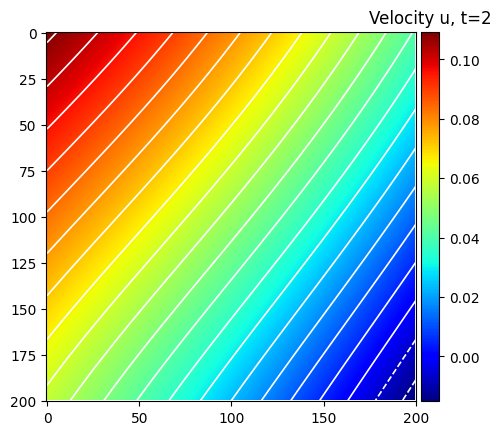

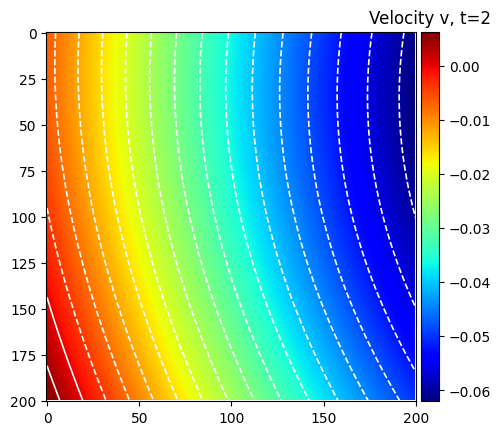

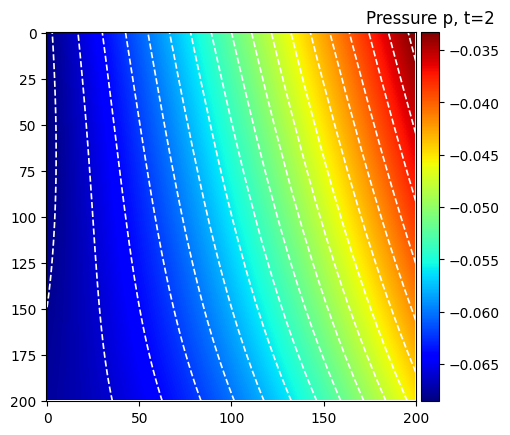

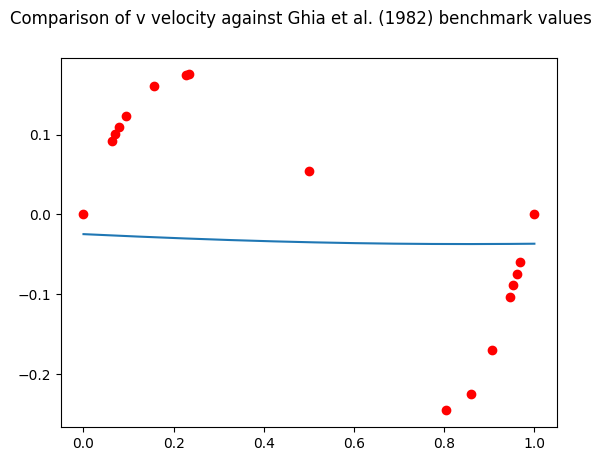

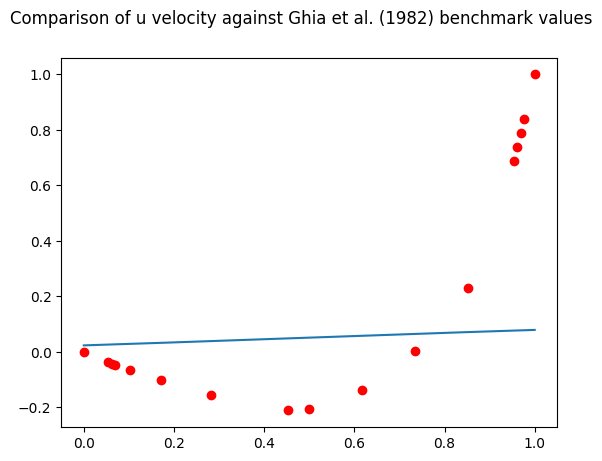

In [29]:
plot_graphs(timestamp=tf)